In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import re
from scipy.sparse import hstack
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score

In [210]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('test.csv')

In [211]:
le = LabelEncoder()
y_train = le.fit_transform(train_df['GeneType'])
y_test = le.transform(test_df['GeneType'])
y_val = le.transform(val_df['GeneType'])

std_scaler = StandardScaler()
tfid_seq = TfidfVectorizer(analyzer='char', ngram_range=(3,3))
tfid_desc = TfidfVectorizer(max_features=100)
GroupMethodLe = LabelEncoder()

In [212]:
train_df.head()

,Unnamed: 0,NCBIGeneID,Symbol,Description,GeneType,GeneGroupMethod,NucleotideSequence
0,0,106481178,RNU4-21P,"RNA, U4 small nuclear 21, pseudogene",PSEUDO,NCBI Ortholog,<AGCTTAGCACAGTGGCAGTATCATAGGCAGTGAGGTTTATCCGAG...
1,1,123477792,LOC123477792,Sharpr-MPRA regulatory region 12926,BIOLOGICAL_REGION,NCBI Ortholog,<CTGGAGCGGCCACGATGTGAACTGTCACCGGCCACTGCTGCTCCG...
2,2,113174975,LOC113174975,Sharpr-MPRA regulatory region 7591,BIOLOGICAL_REGION,NCBI Ortholog,<TTCCCAATTTTTCCTCTGCTTTTTAATTTTCTAGTTTCCTTTTTC...
3,3,116216107,LOC116216107,CRISPRi-validated cis-regulatory element chr10...,BIOLOGICAL_REGION,NCBI Ortholog,<CGCCCAGGCTGGAGTGCAGTGGCGCCATCTCGGCTCACTGCAGGC...
4,4,28502,IGHD2-21,immunoglobulin heavy diversity 2-21,OTHER,NCBI Ortholog,<AGCATATTGTGGTGGTGACTGCTATTCC>


In [213]:
train_df.isnull().sum()

,0
Unnamed: 0,0
NCBIGeneID,0
Symbol,0
Description,0
GeneType,0
GeneGroupMethod,0
NucleotideSequence,0


In [214]:
train_df['Symbol'].value_counts()

,count
Symbol,
TRNAG-GCC,15
TRNAG-UCC,12
TRNAE-CUC,12
TRNAL-CAG,12
TRNAD-GUC,12
...,...
RNA5SP36,1
LOC122149320,1
MIR412,1


In [215]:
def preprocessing(df):
  X = []
  df = df.drop('Unnamed: 0', axis=1)
  df = df.dropna()
  df['NucleotideSequence'] = df['NucleotideSequence'].str.replace("<", "").replace(">", "")
  df['SequenceLength'] = df['NucleotideSequence'].str.len()
  return df

In [216]:
train_df = preprocessing(train_df)
train_df.head()

,NCBIGeneID,Symbol,Description,GeneType,GeneGroupMethod,NucleotideSequence,SequenceLength
0,106481178,RNU4-21P,"RNA, U4 small nuclear 21, pseudogene",PSEUDO,NCBI Ortholog,AGCTTAGCACAGTGGCAGTATCATAGGCAGTGAGGTTTATCCGAGG...,127
1,123477792,LOC123477792,Sharpr-MPRA regulatory region 12926,BIOLOGICAL_REGION,NCBI Ortholog,CTGGAGCGGCCACGATGTGAACTGTCACCGGCCACTGCTGCTCCGA...,296
2,113174975,LOC113174975,Sharpr-MPRA regulatory region 7591,BIOLOGICAL_REGION,NCBI Ortholog,TTCCCAATTTTTCCTCTGCTTTTTAATTTTCTAGTTTCCTTTTTCC...,296
3,116216107,LOC116216107,CRISPRi-validated cis-regulatory element chr10...,BIOLOGICAL_REGION,NCBI Ortholog,CGCCCAGGCTGGAGTGCAGTGGCGCCATCTCGGCTCACTGCAGGCT...,277
4,28502,IGHD2-21,immunoglobulin heavy diversity 2-21,OTHER,NCBI Ortholog,AGCATATTGTGGTGGTGACTGCTATTCC>,29


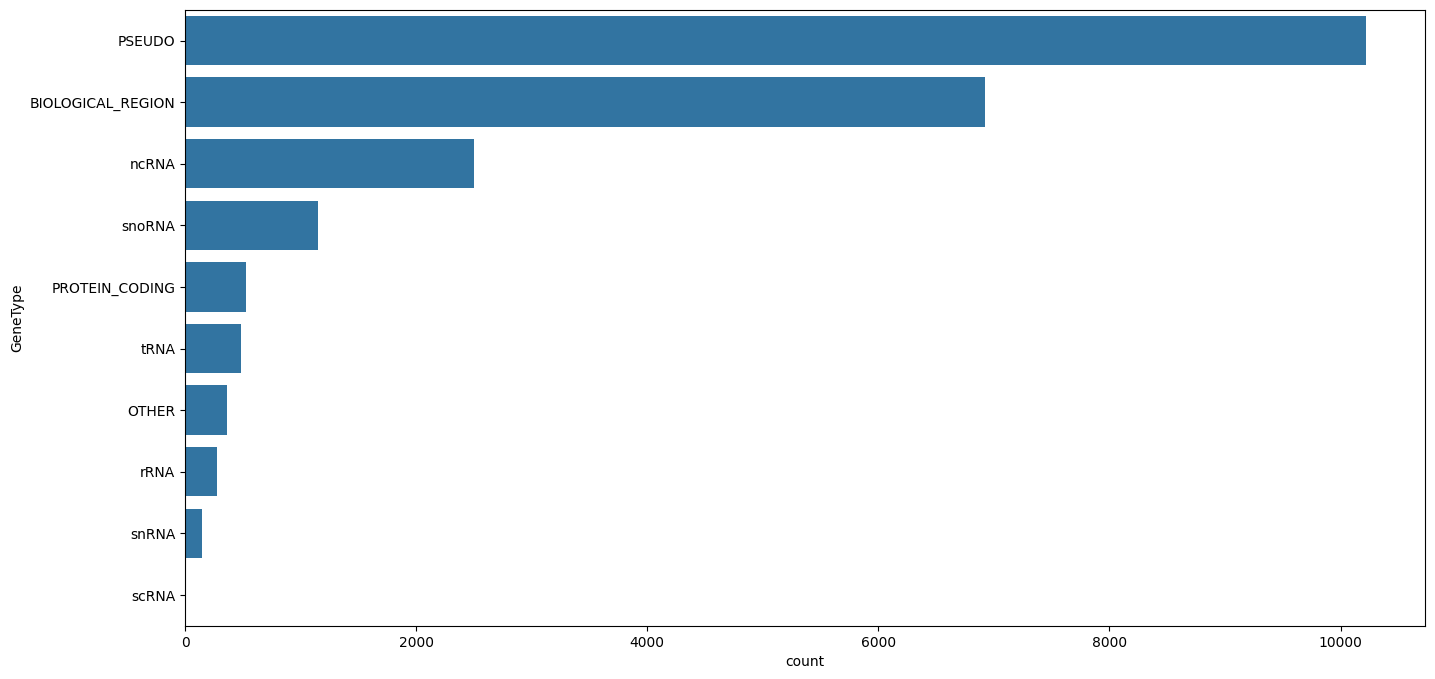

In [217]:
plt.figure(figsize=(16,8))
sns.countplot(data=train_df, y='GeneType', order=train_df['GeneType'].value_counts().index)
plt.show()

<Axes: xlabel='GeneType', ylabel='SequenceLength'>

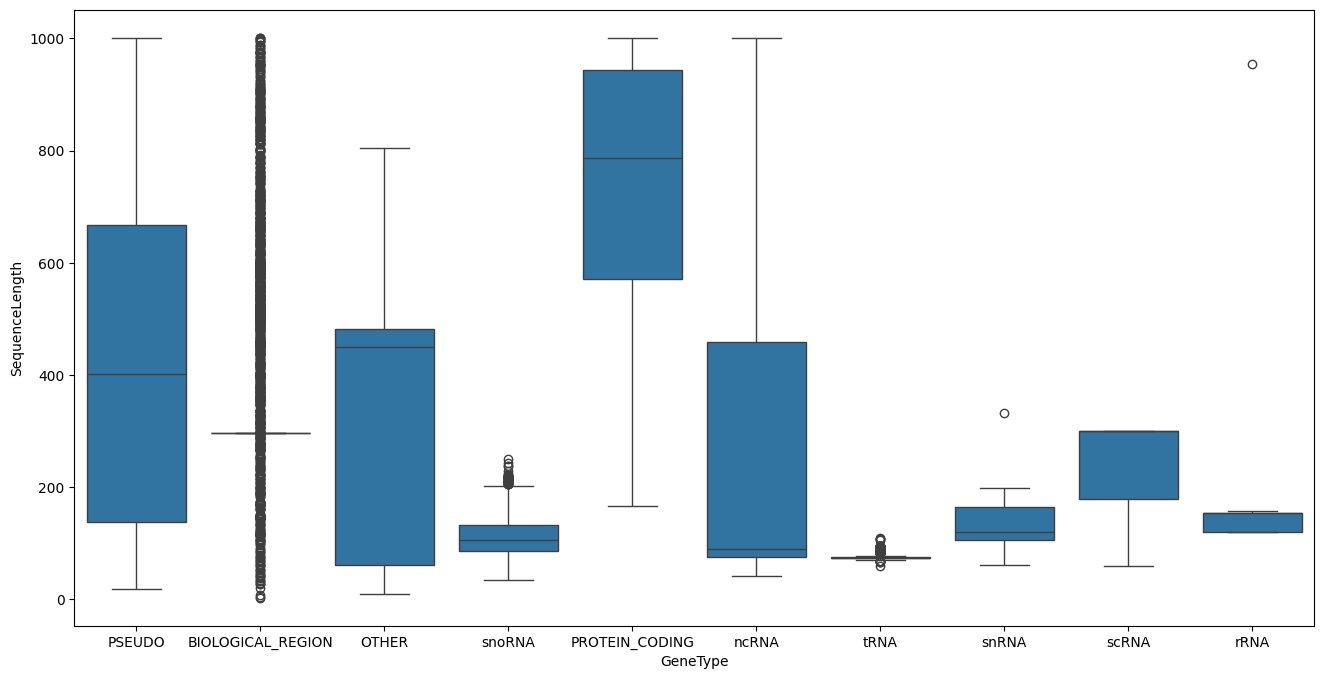

In [218]:
plt.figure(figsize=(16,8))
sns.boxplot(data=train_df, x = 'GeneType', y = 'SequenceLength')

In [219]:
val_df = preprocessing(val_df)
test_df = preprocessing(test_df)

In [241]:
def dftransform(df, type_ = 'train'):

  desc = df['Symbol'] + ' ' + df['Description']
  desc = desc.apply(lambda x: re.sub('[^a-zA-Z0-9]', ' ', x))

  if type_ == 'train':
    print('Using fit transform...')
    GroupM = GroupMethodLe.fit_transform(df['GeneGroupMethod'])
    SeqL = std_scaler.fit_transform(df['SequenceLength'].values.reshape(-1,1))
    SeqVector = tfid_seq.fit_transform(df['NucleotideSequence'].astype(str).values)
    DescVector = tfid_desc.fit_transform(desc.astype(str).values)
  else:
    print('Using only transform...')
    GroupM = GroupMethodLe.transform(df['GeneGroupMethod'])
    SeqL = std_scaler.transform(df['SequenceLength'].values.reshape(-1,1))
    SeqVector = tfid_seq.transform(df['NucleotideSequence'].astype(str).values)
    DescVector = tfid_desc.transform(desc.astype(str).values)

  return GroupM.reshape(-1,1), SeqL.reshape(-1,1), SeqVector, DescVector

In [242]:
GroupM, SeqL, SeqV, DescV = dftransform(train_df)

X_train = hstack([
    GroupM,
    SeqL,
    SeqV,
    DescV
])

GroupM, SeqL, SeqV, DescV = dftransform(val_df, 'val')

X_val = hstack([
    GroupM,
    SeqL,
    SeqV,
    DescV
])

GroupM, SeqL, SeqV, DescV = dftransform(test_df, 'val')

X_test = hstack([
    GroupM,
    SeqL,
    SeqV,
    DescV
])

Using fit transform...
Using only transform...
Using only transform...


In [222]:
X_train.toarray()

array([[ 0.        , -0.8973233 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.2484936 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.2484936 ,  0.03980135, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , -0.33295664,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.08168009,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -1.10464166,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [224]:
model = Sequential([
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax'),
])

model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [225]:
model.fit(x=X_train, y = y_train, validation_data=(X_val, y_val), epochs=25)

Epoch 1/25
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8405 - loss: 0.5386 - val_accuracy: 0.9747 - val_loss: 0.0854
Epoch 2/25
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9705 - loss: 0.0803 - val_accuracy: 0.9757 - val_loss: 0.0750
Epoch 3/25
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9770 - loss: 0.0687 - val_accuracy: 0.9784 - val_loss: 0.0588
Epoch 4/25
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9783 - loss: 0.0605 - val_accuracy: 0.9801 - val_loss: 0.0559
Epoch 5/25
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9798 - loss: 0.0556 - val_accuracy: 0.9784 - val_loss: 0.0573
Epoch 6/25
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9805 - loss: 0.0540 - val_accuracy: 0.9766 - val_loss: 0.0559
Epoch 7/25
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9795 - loss: 0.0555 - val_accuracy: 0.9821 - val_loss: 0.0492
Epoch 8/25
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9818 - loss: 0.0498 - val_accuracy: 0.

In [240]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
ac = accuracy_score(y_test, y_pred_classes)
print('Accuracy score', ac)

outs = []
i = 0
for y in y_pred:
  pred_classes = le.inverse_transform([np.argmax(y)])[0]
  pred_prob = np.max(y)
  outs.append([i, pred_classes, pred_prob])
  i += 1

print(np.array(outs)[0:100])


261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy score 0.990511650252222
[['0' 'BIOLOGICAL_REGION' '0.99999994']
 ['1' 'snRNA' '0.9907105']
 ['2' 'BIOLOGICAL_REGION' '0.99999994']
 ['3' 'OTHER' '0.9999986']
 ['4' 'PSEUDO' '0.99999195']
 ['5' 'BIOLOGICAL_REGION' '0.99999994']
 ['6' 'BIOLOGICAL_REGION' '0.99999994']
 ['7' 'BIOLOGICAL_REGION' '0.99999994']
 ['8' 'PSEUDO' '0.99999994']
 ['9' 'PROTEIN_CODING' '0.99963063']
 ['10' 'BIOLOGICAL_REGION' '0.99999994']
 ['11' 'PSEUDO' '0.99999994']
 ['12' 'BIOLOGICAL_REGION' '0.99999994']
 ['13' 'BIOLOGICAL_REGION' '0.99999994']
 ['14' 'PSEUDO' '0.9999983']
 ['15' 'PSEUDO' '0.99934375']
 ['16' 'ncRNA' '0.99973905']
 ['17' 'BIOLOGICAL_REGION' '0.99999994']
 ['18' 'PSEUDO' '0.99991363']
 ['19' 'PSEUDO' '0.99999994']
 ['20' 'PSEUDO' '0.9999998']
 ['21' 'BIOLOGICAL_REGION' '0.99999994']
 ['22' 'BIOLOGICAL_REGION' '0.99999994']
 ['23' 'PSEUDO' '0.99999994']
 ['24' 'PSEUDO' '0.9999996']
 ['25' 'PSEUDO' '0.99999994']
 ['26' 'BIOLOGICAL_REGION' '0.99999